# 🌐 Wikipedia recommender system
- Zuzanna Gawrysiak 148255
- Agata Żywot 148258

### Description (straight from ekursy - to be deleted later)


The general task is to create a system that will recommend similar articles based on the previously visited articles.

**Input - Collection of articles (links or titles), Output - Collection of recommended articles (links or titles) with a "score"**


You will receive a grade for each of the following steps. The highest possible score without
finishing all parts is 4.0. For example, if you do perfectly the first two steps your grades will be 4.0,
4.0, 2.0.


**Crawling and scraping** - Download text from at least 1000 Wikipedia/fandom wiki articles.
(Scrappy is not a must)


**Stemming, lemmatization** - preprocess downloaded documents into the most suitable form for this
task. Store it as a .csv/parquet file or into a database.


**Similarities** - for a given collection of previously visited articles find the best matches in your
database and recommend them to the user


GUI not required, notebook or any other reasonable form will be accepted. I have to be able to
provide a list of articles in an easy way and receive a meaningful recommendation.
You have to send the source code and report.


Report:
- pdf or notebook
- explain each step of your algorithm, especially how you score articles
- present interesting statistics about your database (most frequent words, histograms, similarities
between documents, ...)
- show some examples of recommendations with explanations (I'd prefer graphical form - see
prediction breakdowns for example)

## Import necessary libraries

In [ ]:
%pip install pyldavis
%pip install wikipedia

In [10]:
import random
import linecache
import wikipedia
import re
import requests
import bs4
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from wordcloud import WordCloud
from time import sleep

import pyLDAvis
import pyLDAvis.sklearn

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping wikipedia articles

In [9]:
def getText(url):
    response = requests.get(url)
    assert(response.status_code == 200)
    parsed = bs4.BeautifulSoup(response.text)
    output = ""
    for p in parsed.select('p'):
      output += p.getText()
    return output

In [18]:
def preprocess(article):
    """
    Tokenize given article, remove stopwords, numbers, then perform stemming
    """
    preprocessed = []
    porter = PorterStemmer()
    tokenized = word_tokenize(article)
    sw = stopwords.words('english')

    for word in tokenized:
        if word.isalpha() and word not in sw:
            preprocessed.append(porter.stem(word)) # stemming is faster than lematization, but has lower accuracy (can try both later)
    return ' '.join(preprocessed)

In [53]:
def bfs(link):

  df = pd.DataFrame({'url':[],
                      'body':[]})

  to_visit = [link]
  visited = set()
  while(len(to_visit)!=0 and len(visited)<1000):
    sleep(random.random()*3)
    url = to_visit.pop(0)
    if url not in visited:
      response = requests.get(url)

      if response.status_code == 200:
        visited.add(url)
      else:
        print("Error: ", response.status_code, url)
        continue

      parsed = bs4.BeautifulSoup(response.text)
      body = ""
      for p in parsed.select('p'):
        body += p.getText()


      df.loc[len(df.index)] = [url, preprocess(body)]
      print('!!!')
      # print(df.head())
      
        
      links = parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})
      random.shuffle(links)

      print(url)
      # print(links)
      
      for l in links:
        to_visit.append("https://en.wikipedia.org/" + l.text)
  df.to_csv('./data/articles2.csv', encoding='utf-8', index=False)

In [54]:
bfs('https://en.wikipedia.org/wiki/Cat')

!!!
https://en.wikipedia.org/wiki/Cat
Error:  404 https://en.wikipedia.org/White-nosed coati (N. narica)
Error:  404 https://en.wikipedia.org/The South Island piopio
Error:  404 https://en.wikipedia.org/Library cat
Error:  404 https://en.wikipedia.org/Sokoke
Error:  404 https://en.wikipedia.org/Read
Error:  404 https://en.wikipedia.org/doi
Error:  404 https://en.wikipedia.org/immune
Error:  404 https://en.wikipedia.org/Sand cat (F. margarita)
Error:  404 https://en.wikipedia.org/PMC
Error:  404 https://en.wikipedia.org/South Africa
Error:  404 https://en.wikipedia.org/doi
Error:  404 https://en.wikipedia.org/Articles containing Irish-language text
Error:  404 https://en.wikipedia.org/Galidia
Error:  404 https://en.wikipedia.org/Masked palm civet (P. larvata)
Error:  404 https://en.wikipedia.org/Norse mythology
Error:  404 https://en.wikipedia.org/PMID
Error:  404 https://en.wikipedia.org/cone cells
Error:  404 https://en.wikipedia.org/Lesser grison (G. cuja)


KeyboardInterrupt: 

## Stemming, lemmatization

In [25]:
df = pd.read_csv('./data/articles2.csv')
df.tail()

,url,body
0,https://en.wikipedia.org/wiki/Dog,the dog cani familiari cani lupu familiari dom...
1,https://en.wikipedia.org/,roberta william born american video game desig...


## Count vector
Store articles as numbers of occurences of words.

In [26]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(df.body)
 
CountData
# if dataset is too large, try: https://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick 

<2x1458 sparse matrix of type '<class 'numpy.int64'>'
	with 1505 stored elements in Compressed Sparse Row format>

In [27]:
pd.set_option('display.max_columns', 1000)
dfCV = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=df.url)
dfCV

,aardwolf,abdomin,abil,aboard,abou,absente,abund,academi,accept,accid,accompani,accord,account,accus,achiev,acid,acquir,acquisit,act,action,activ,acut,adam,adapt,addit,adhd,adopt,adult,advanc,advantag,adventur,advis,affect,africa,afterward,age,agenc,aggress,agil,ago,agreement,agricultur,aid,ailment,aim,airlin,alert,aliv,allergi,allow,alpha,altogeth,alzheim,ambival,america,american,amur,amylas,analysi,ancestor,ancestri,ancient,anim,annual,annwn,anoth,antarctica,antiqu,antisoci,anxieti,ape,appear,appli,approach,appropri,arab,archaeologist,arctic,area,arginin,argu,arrang,arteri,arthriti,articl,artifici,asia,asian,aspca,assess,assist,associ,attach,attack,attend,attribut,attun,audienc,australian,author,autoimmun,avail,averag,avoid,award,away,babylonian,balanc,bamboo,ban,basalt,base,basic,basset,beach,bear,beaten,becam,becaus,becom,beef,began,behavior,behaviour,believ,benefici,benefit,berlioz,bernes,bertin,best,better,bhairava,big,bile,binomi,bite,bitten,black,blaze,blind,bloat,block,bloodi,bodi,boil,bold,bond,bone,book,border,born,bosintang,botanist,boxer,brachycephal,brain,bred,breed,bridg,brittani,broad,broaden,brought,buddhism,build,buri,busi,butt,cafe,cage,cairn,cambon,cameron,cancer,cani,canid,canida,caniform,canin,canina,canton,capabl,cardiovascular,care,caretak,carl,carnassi,carnivor,carnivora,carnivoran,case,castrat,cat,catecholamin,categori,cathol,cauda,caus,cave,cemeteri,center,central,centuri,cerberu,certain,chang,characterist,chaser,chemic,chest,chicken,childhood,children,chili,chimpanze,china,chinvat,chocol,choic,christian,christoph,church,churchyard,cigar,citat,clade,claim,class,classic,classifi,claw,cleft,climat,close,closest,coars,coat,coeffici,cognit,colder,collaps,colli,color,colour,come,command,commenc,commens,commerci,commiss,commod,commodif,commodifi,common,commonli,commun,companion,companionship,compar,compel,compet,competit,competitor,complex,compon,compos,concept,condit,conduct,confin,conform,connect,consid,consider,consist,consum,consumpt,contact,contain,contemporari,contextu,continu,contribut,control,convers,convey,coordin,copi,copiou,copul,corgi,corkscrew,cornéli,coronari,correctli,correl,countri,coutur,coyot,creat,creativ,creator,credit,critic,crown,crucial,cruciat,cruelti,crush,cuc,cuerdenwikipedia,cultur,cure,curl,current,custom,cut,cutan,cycl,cŵn,dachshund,damag,danc,danger,data,date,day,deaf,deal,death,debat,decad,decept,decis,decreas,dedic,delay,deleteri,demand,demonstr,deni,denomin,dental,depict,depress,deriv,descend,describ,design,detect,develop,diabet,diarrhea,dicaprio,die,diet,differ,difficult,digest,dilat,dingo,dinosaur,direct,director,disabl,disadvantag,disast,discov,diseas,dish,dislik,disord,dispers,display,disprov,disput,disrupt,distanc,distemp,distinct,distribut,disulfid,diverg,divers,dna,dobruja,dock,doctor,document,dog,doghous,dolichocephal,domest,domin,domini,dominican,doubl,drama,draw,dreamt,drive,drug,dwarfism,dwell,dynasti,dysplasia,earli,earlier,earliest,earth,east,eastern,eastward,eat,ecclesiast,edit,editor,educ,effect,egg,el,elbow,elderli,elimin,elit,elong,emblem,embryo,emot,enabl,enamel,end,energi,engag,england,english,enhanc,enorm,ensu,ensur,enter,entir,environ,epic,epilepsi,equal,era,eschew,esmeralda,especi,establish,estim,estrou,eurasia,europ,european,euthan,evalu,eve,event,eventu,everi,everyday,evid,evolut,evolutionari,exampl,exclus,exemplifi,exercis,exhibit,exist,expand,expect,expens,experi,experienc,experiment,explain,exposur,express,extens,extent,extern,extinct,extra,eye,face,facial,facilit,factor,fadl,fail,faith,falcon,fall,fals,famili,familiar,...,percentag,perform,perfum,period,permit,persecut,persian,person,pet,phantasmagoria,phenotyp,pheromon,philippin,phoebu,physic,pictur,pioneer,place,plain,play,playmat,pleistocen,plenti,point,pointer,poison,poland,polic,polynesia,poorli,popul,popular,pork,posit,possess,possibl,postur,potenti,powder,power,practic,practition,predat,prefer,pregnanc,pregnant,prematur,premier,premolar,prepar,presenc,present,preval,prevent,primari,primari

## Database analysis
> present interesting statistics about your database (most frequent words, histograms, similarities between documents, ...)

### Most frequent words

Top five most frequent words:
dog       283
human      50
pet        35
breed      32
domest     31
dtype: int64


<AxesSubplot:title={'center':'Most frequent words'}>

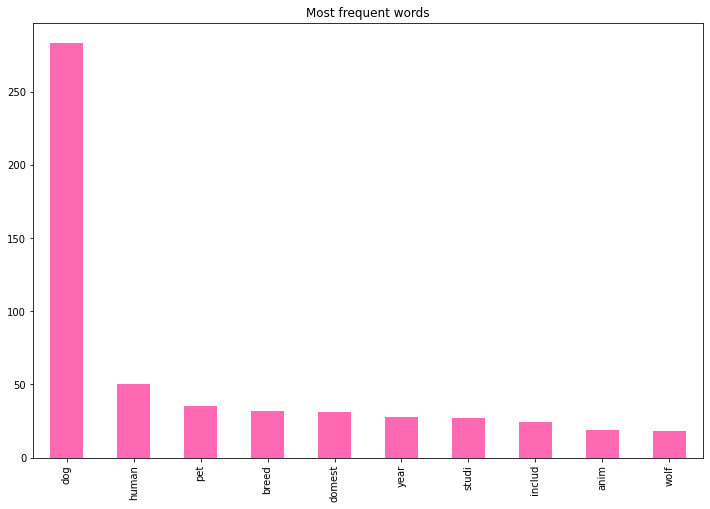

In [28]:
word_sums = dfCV.sum(axis=0)
word_sums = word_sums.sort_values(ascending=False)
print(f"Top five most frequent words:\n{word_sums[:5]}")
word_sums[:10].plot(kind='bar', figsize=(12,8), title="Most frequent words", color='hotpink')

All words as a wordcloud

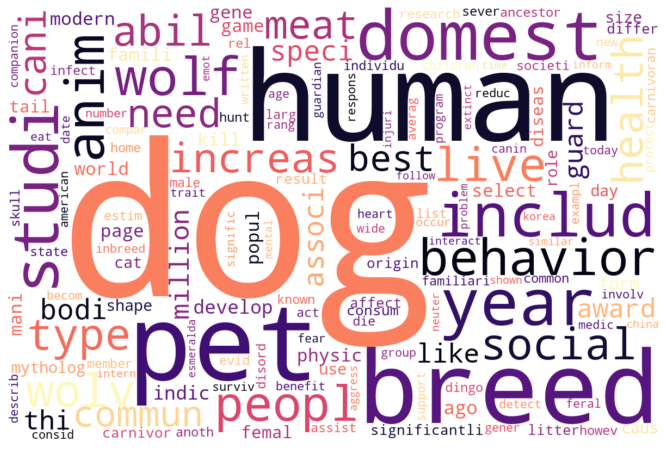

In [29]:
def generate_wordcloud(data):
    wc = WordCloud(width=1200, height=800, max_words=150, background_color='white', colormap='magma').generate_from_frequencies(data)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(word_sums)

### Similarities between documents

Check the similarities using LDA (Latent Drichlet Allocation). 

In [33]:
from jupyterthemes import jtplot

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [34]:
lda_tf = LatentDirichletAllocation(n_components=100, random_state=0) # number of articles
lda_tf.fit(CountData)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, CountData, CountVec, mds='tsne')
panel

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\ag

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
37      2.258950  -1.583599       1        1  92.230799
92     21.447607  53.648537       2        1   7.712911
0       1.785142  -0.623279       3        1   0.000574
63      2.754075  -0.350192       4        1   0.000574
72      1.785218  -0.623492       5        1   0.000574
...          ...        ...     ...      ...        ...
30      1.785142  -0.623279      96        1   0.000574
29      1.716622  -0.666876      97        1   0.000574
28      1.716782  -0.667206      98        1   0.000574
27      1.785142  -0.623279      99        1   0.000574
99      1.785217  -0.623489     100        1   0.000574

[100 rows x 5 columns], topic_info=         Term        Freq       Total  Category  logprob  loglift
390       dog  281.000000  281.000000   Default  30.0000  30.0000
639     human   49.000000   49.000000   Default  29.0000  29.0000
966       pet   34.000000   34.000000   Default  28.0000  28.0000
158     breed   31.000000   31.000000   Default  27.0000  27.0000
393    domest   30.000000   30.000000   Default  26.0000  26.0000
..        ...         ...         ...       ...      ...      ...
25       adhd    0.000014    1.015913  Topic100  -7.2848   0.8527
26      adopt    0.000014    1.015913  Topic100  -7.2848   0.8527
27      adult    0.000014    1.015913  Topic100  -7.2848   0.8527
28     advanc    0.000014    2.011082  Topic100  -7.2848   0.1699
29   advantag    0.000014    1.015913  Topic100  -7.2848   0.8527

[5783 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.984336  aardwolf
1         1  0.984336   abdomin
2         1  1.003246      abil
3         1  0.984336    aboard
4         1  0.984336      abou
...     ...       ...       ...
1439      1  1.003692      wolf
1440      1  1.003460      wolv
1451      2  1.053417   written
1455      1  0.901375      year
1455      2  0.108165      year

[133 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[38, 93, 1, 64, 73, 72, 71, 70, 69, 68, 67, 66, 65, 63, 75, 62, 61, 60, 59, 58, 57, 56, 55, 54, 74, 76, 52, 77, 99, 98, 97, 96, 95, 94, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 53, 51, 2, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 24, 26, 50, 27, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 100])

### Conclusions from analysis
* the most frequent word is ...
* bla bla

## TFIDF approach
Count vector was for showing some interesteing statistics, but for the recommendation we will use TFIDF.

In [35]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
tfidf_data = tfidf.fit_transform(df.body) 
dfTFIDF = pd.DataFrame(tfidf_data.toarray(), index=df.url, columns=tfidf.get_feature_names_out())
dfTFIDF

,aardwolf,abdomin,abil,aboard,abou,absente,abund,academi,accept,accid,accompani,accord,account,accus,achiev,acid,acquir,acquisit,act,action,activ,acut,adam,adapt,addit,adhd,adopt,adult,advanc,advantag,adventur,advis,affect,africa,afterward,age,agenc,aggress,agil,ago,agreement,agricultur,aid,ailment,aim,airlin,alert,aliv,allergi,allow,alpha,altogeth,alzheim,ambival,america,american,amur,amylas,analysi,ancestor,ancestri,ancient,anim,annual,annwn,anoth,antarctica,antiqu,antisoci,anxieti,ape,appear,appli,approach,appropri,arab,archaeologist,arctic,area,arginin,argu,arrang,arteri,arthriti,articl,artifici,asia,asian,aspca,assess,assist,associ,attach,attack,attend,attribut,attun,audienc,australian,author,autoimmun,avail,averag,avoid,award,away,babylonian,balanc,bamboo,ban,basalt,base,basic,basset,beach,bear,beaten,becam,becaus,becom,beef,began,behavior,behaviour,believ,benefici,benefit,berlioz,bernes,bertin,best,better,bhairava,big,bile,binomi,bite,bitten,black,blaze,blind,bloat,block,bloodi,bodi,boil,bold,bond,bone,book,border,born,bosintang,botanist,boxer,brachycephal,brain,bred,breed,bridg,brittani,broad,broaden,brought,buddhism,build,buri,busi,butt,cafe,cage,cairn,cambon,cameron,cancer,cani,canid,canida,caniform,canin,canina,canton,capabl,cardiovascular,care,caretak,carl,carnassi,carnivor,carnivora,carnivoran,case,castrat,cat,catecholamin,categori,cathol,cauda,caus,cave,cemeteri,center,central,centuri,cerberu,certain,chang,characterist,chaser,chemic,chest,chicken,childhood,children,chili,chimpanze,china,chinvat,chocol,choic,christian,christoph,church,churchyard,cigar,citat,clade,claim,class,classic,classifi,claw,cleft,climat,close,closest,coars,coat,coeffici,cognit,colder,collaps,colli,color,colour,come,command,commenc,commens,commerci,commiss,commod,commodif,commodifi,common,commonli,commun,companion,companionship,compar,compel,compet,competit,competitor,complex,compon,compos,concept,condit,conduct,confin,conform,connect,consid,consider,consist,consum,consumpt,contact,contain,contemporari,contextu,continu,contribut,control,convers,convey,coordin,copi,copiou,copul,corgi,corkscrew,cornéli,coronari,correctli,correl,countri,coutur,coyot,creat,creativ,creator,credit,critic,crown,crucial,cruciat,cruelti,crush,cuc,cuerdenwikipedia,cultur,cure,curl,current,custom,cut,cutan,cycl,cŵn,dachshund,damag,danc,danger,data,date,day,deaf,deal,death,debat,decad,decept,decis,decreas,dedic,delay,deleteri,demand,demonstr,deni,denomin,dental,depict,depress,deriv,descend,describ,design,detect,develop,diabet,diarrhea,dicaprio,die,diet,differ,difficult,digest,dilat,dingo,dinosaur,direct,director,disabl,disadvantag,disast,discov,diseas,dish,dislik,disord,dispers,display,disprov,disput,disrupt,distanc,distemp,distinct,distribut,disulfid,diverg,divers,dna,dobruja,dock,doctor,document,dog,doghous,dolichocephal,domest,domin,domini,dominican,doubl,drama,draw,dreamt,drive,drug,dwarfism,dwell,dynasti,dysplasia,earli,earlier,earliest,earth,east,eastern,eastward,eat,ecclesiast,edit,editor,educ,effect,egg,el,elbow,elderli,elimin,elit,elong,emblem,embryo,emot,enabl,enamel,end,energi,engag,england,english,enhanc,enorm,ensu,ensur,enter,entir,environ,epic,epilepsi,equal,era,eschew,esmeralda,especi,establish,estim,estrou,eurasia,europ,european,euthan,evalu,eve,event,eventu,everi,everyday,evid,evolut,evolutionari,exampl,exclus,exemplifi,exercis,exhibit,exist,expand,expect,expens,experi,experienc,experiment,explain,exposur,express,extens,extent,extern,extinct,extra,eye,face,facial,facilit,factor,fadl,fail,faith,falcon,fall,fals,famili,familiar,...,percentag,perform,perfum,period,permit,persecut,persian,person,pet,phantasmagoria,phenotyp,pheromon,philippin,phoebu,physic,pictur,pioneer,place,plain,play,playmat,pleistocen,plenti,point,pointer,poison,poland,polic,polynesia,poorli,popul,popular,pork,posit,possess,possibl,postur,potenti,powder,power,practic,practition,predat,prefer,pregnanc,pregnant,prematur,premier,premolar,prepar,presenc,present,preval,prevent,primari,primari

Save the obtained data frame to csv file.

## Recommender system - similarities

In [10]:
def get_recommendations(df, user_data, mode='query', n=10):
    tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
    tfidf.fit_transform(df.body)
    query = None

    if mode == 'query':
        if isinstance(user_data, list):
            user_data = ' '.join(user_data)
        query = preprocess(user_data)
    
    elif mode == 'url':
        if isinstance(user_data, list):
            query = ''
            for url in user_data:
                query = query + ' ' + preprocess(getText(url))
            
        else:
            query = preprocess(getText(url))

    if query is None:
        return None   
         
    query = tfidf.transform([query]).toarray()[0] 
    return 1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()[:n]

In [13]:
QUERY = 'alternative medicine'
results_query = get_recommendations(df, QUERY)
print(f'Results recommended for the following query: {QUERY}')
print(results_query)

Results recommended for the following query: alternative medicine
url
https://en.wikipedia.org/wiki/Regenerative_medicine                          0.225541
https://en.wikipedia.org/wiki/James_Hamblin_(journalist)                     0.172645
https://en.wikipedia.org/wiki/Peter_Kopelman                                 0.069333
https://en.wikipedia.org/wiki/List_of_emergency_medicine_courses             0.066597
https://en.wikipedia.org/wiki/National_University_of_Colombia                0.065183
https://en.wikipedia.org/wiki/Sterol_regulatory_element-binding_protein_1    0.049201
https://en.wikipedia.org/wiki/Stellastarr                                    0.043820
https://en.wikipedia.org/wiki/PITX2                                          0.034754
https://en.wikipedia.org/wiki/Bromide,_Oklahoma                              0.031856
https://en.wikipedia.org/wiki/RPS6KA1                                        0.031143
dtype: float64


In [14]:
URL = [ 'https://en.wikipedia.org/wiki/Google',
        'https://en.wikipedia.org/wiki/Mobile_phone']
results_url = get_recommendations(df, URL, mode='url')
print(f'Results recommended for the following urls: {URL}')
print(results_url)

Results recommended for the following urls: ['https://en.wikipedia.org/wiki/Google', 'https://en.wikipedia.org/wiki/Mobile_phone']
url
https://en.wikipedia.org/wiki/GSM_services                   0.376283
https://en.wikipedia.org/wiki/Visual_search_engine           0.181718
https://en.wikipedia.org/wiki/Industrial_espionage           0.173150
https://en.wikipedia.org/wiki/Multi-factor_authentication    0.167883
https://en.wikipedia.org/wiki/Samsung_Galaxy_Note_9          0.115593
https://en.wikipedia.org/wiki/Advanced_Video_Coding          0.104422
https://en.wikipedia.org/wiki/Lenovo                         0.101690
https://en.wikipedia.org/wiki/Adam_Aircraft_Industries       0.099587
https://en.wikipedia.org/wiki/LexisNexis                     0.093084
https://en.wikipedia.org/wiki/Minds                          0.092485
dtype: float64
